In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)

In [2]:
from sklearn.preprocessing import OrdinalEncoder
df = pd.read_csv('base_calibracao.csv')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,1,999,0,1.0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7.0,1.0,3.0,1.0,0.0,0.0,1.0,6.0,1.0,1,999,0,1.0,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7.0,1.0,3.0,0.0,2.0,0.0,1.0,6.0,1.0,1,999,0,1.0,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0.0,1.0,1.0,0.0,0.0,0.0,1.0,6.0,1.0,1,999,0,1.0,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7.0,1.0,3.0,0.0,0.0,2.0,1.0,6.0,1.0,1,999,0,1.0,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,5.0,1.0,5.0,0.0,2.0,0.0,0.0,7.0,0.0,1,999,0,1.0,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,1.0,1.0,5.0,0.0,0.0,0.0,0.0,7.0,0.0,1,999,0,1.0,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,5.0,1.0,6.0,0.0,2.0,0.0,0.0,7.0,0.0,2,999,0,1.0,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,9.0,1.0,5.0,0.0,0.0,0.0,0.0,7.0,0.0,1,999,0,1.0,-1.1,94.767,-50.8,1.028,4963.6,1


In [3]:
X = df.drop('y',axis=1)
y = df.y

# TODO: checar missings e, se necessário, fazer fillna

In [4]:
from sklearn.model_selection import train_test_split

X_tr, X_ts, y_tr, y_ts = train_test_split(X,y, test_size=.5, random_state=61658)

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

params = {
    'max_leaf_nodes': np.unique(np.logspace(np.log10(2),3,30,base=10).astype(int)),
}

grid1 = GridSearchCV(
    RandomForestClassifier(n_estimators=500, random_state=61658),
    params,
    cv=5,
    scoring='roc_auc',
    n_jobs=3,
    verbose=10
)

grid1.fit(X_tr,y_tr)

print(grid1.best_params_)
print(roc_auc_score(y_ts, grid1.predict_proba(X_ts)[:,1]))

Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'max_leaf_nodes': 424}
0.7997215575643505


In [6]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

params = {
    'num_leaves': np.unique(np.logspace(np.log10(2),7,15,base=2).astype(int)),
    'n_estimators': [50,100,150,200],
    'reg_alpha': np.logspace(-3,3,5,base=10),
    'reg_lambda': np.logspace(-3,3,5,base=10),
}

grid2 = GridSearchCV(
    LGBMClassifier(n_estimators=500, random_state=61658),
    params,
    cv=5,
    scoring='roc_auc',
    n_jobs=3,
    verbose=10
)

grid2.fit(X_tr,y_tr)

print(grid2.best_params_)
print(roc_auc_score(y_ts, grid2.predict_proba(X_ts)[:,1]))

Fitting 5 folds for each of 1400 candidates, totalling 7000 fits


/home/rafael/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.70748678 0.70748844 0.70748678]
  warnings.warn(


{'n_estimators': 200, 'num_leaves': 6, 'reg_alpha': 0.03162277660168379, 'reg_lambda': 1.0}
0.7977257639716377


# Como comparar os `scores`?

 - Será que <u>nas pontas</u> um modelo é mais **certeiro** do que outro?
 - Se eu dividir em **faróis**, qual a **probabilidade de compra** em cada farol?
 - Será que faz sentido eu informar o gerente sobre **os 2 scores**, ou sobre uma **composição deles**?

(array([3.9544282 , 1.80567498, 0.62596733, 0.79449699, 1.43852107,
        1.0894239 , 0.86070507, 0.83061049, 0.55975924, 0.78245916,
        0.58985383, 0.57179708, 0.08426483, 0.01203783]),
 array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
        0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
        0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ]),
 <BarContainer object of 14 artists>)

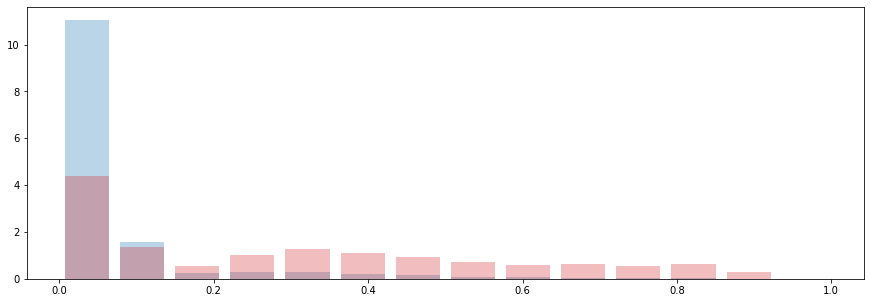

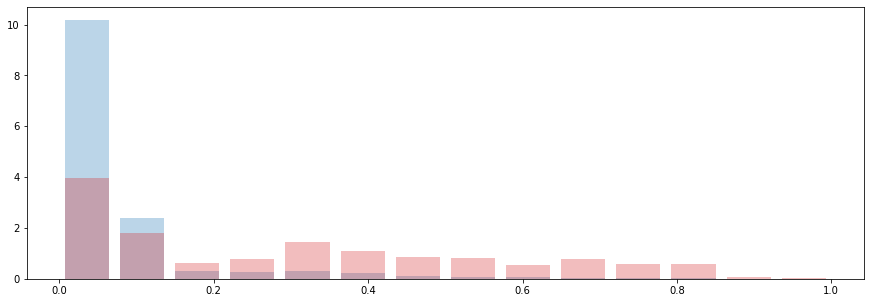

In [7]:
pred1 = grid1.predict_proba(X_ts)[:,1]
pred2 = grid2.predict_proba(X_ts)[:,1]

plt.figure(figsize=(15,5))
plt.hist( pred1[y_ts==0], bins=np.linspace(0,1,15), color='C0', alpha=.3, density=True, rwidth=.8 )
plt.hist( pred1[y_ts==1], bins=np.linspace(0,1,15), color='C3', alpha=.3, density=True, rwidth=.8 )

plt.figure(figsize=(15,5))
plt.hist( pred2[y_ts==0], bins=np.linspace(0,1,15), color='C0', alpha=.3, density=True, rwidth=.8 )
plt.hist( pred2[y_ts==1], bins=np.linspace(0,1,15), color='C3', alpha=.3, density=True, rwidth=.8 )

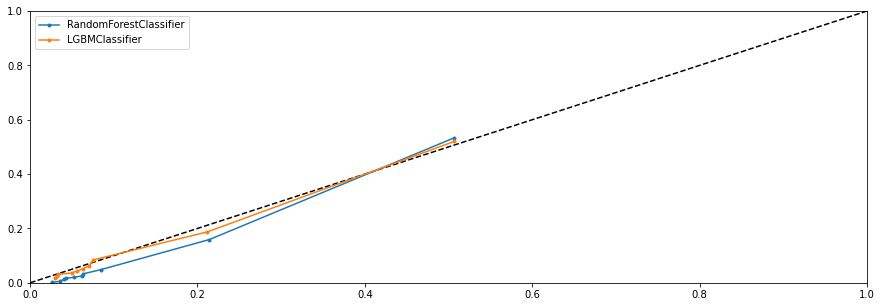

In [8]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(15,5))
plt.plot((0,1),(0,1),'k--')

fraction_of_positives1, mean_predicted_value1 = calibration_curve(y_ts, pred1, n_bins=10, normalize=True, strategy='quantile')
plt.plot(fraction_of_positives1, mean_predicted_value1,'C0.-',label='RandomForestClassifier')

fraction_of_positives2, mean_predicted_value2 = calibration_curve(y_ts, pred2, n_bins=10, normalize=True, strategy='quantile')
plt.plot(fraction_of_positives2, mean_predicted_value2,'C1.-',label='LGBMClassifier')

plt.legend()
plt.xlim(0,1)
plt.ylim(0,1);

# Usando `CalibratedClassifierCV`: modelos pré-treinados

 - Esse objeto vai ajustar um **Regressor de calibração**:
   - Variável preditiva: O score do seu modelo (RandomForestClassifier, por exemplo)
   - Variável resposta: Taxa de eventos para cada faixa de score
   
 - Entretanto, esse **Regressor de calibração** deve satisfazer uma regra muito importante:
   - A função de saída deve ser <u>monotônica crescente</u>, ou seja:
   
$$
Pr(y=1|score) = f(score)
$$

Sujeita a:
<center>Se $x_2>x_1$ então $f(x_2)>f(x_1)$</center>

<hr />

Há 2 formas de fazer isso:

 - Uma é a já conhecida **regressão logística**, que já vimos como um método de calibração.
   - No `CalibratedClassifierCV` podemos usar esse método passando o argumento `method='sigmoid'`
   
 
 - Outra é resolvendo o problema de minimização da **Regressão isotônica**:

$$
\min_{\beta} \left( \sum_i \hat y_i - y_i \right)
$$

Restrita a:

$$
x_i \leqslant x_j \Rightarrow \hat y_i \leqslant \hat y_j
$$

  - No `CalibratedClassifierCV` podemos usar esse método passando o argumento `method='isotonic'`
  
<hr />

### Primeiro vamos ver como fazer isso caso já tenhamos um modelo previamente treinado

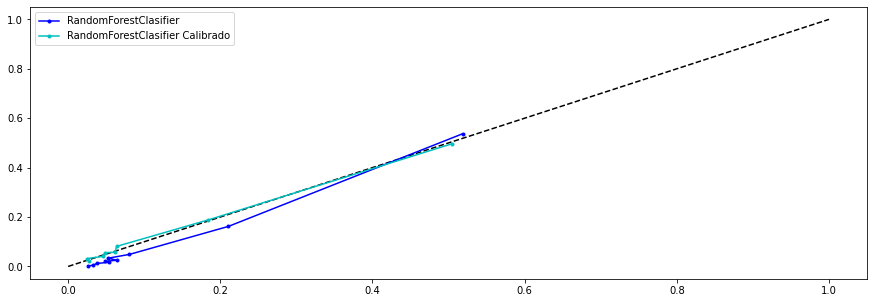

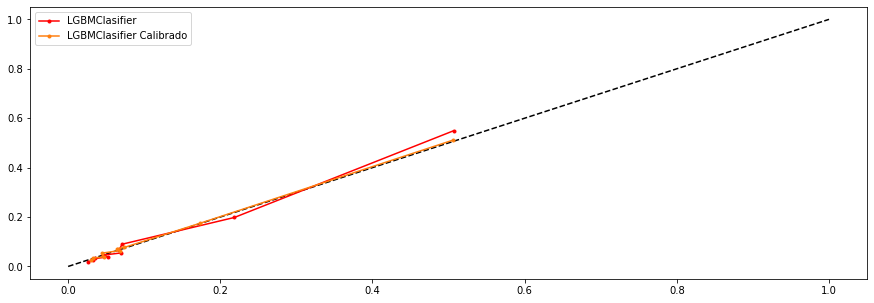

In [9]:
from sklearn.calibration import CalibratedClassifierCV


# Note que, como será treinado um novo modelo, precisamos separar novamente nossos dados em treino e teste!
X_ts1 = X_ts.iloc[:X_ts.shape[0]//2]
y_ts1 = y_ts.iloc[:X_ts.shape[0]//2]

X_ts2 = X_ts.iloc[X_ts.shape[0]//2:]
y_ts2 = y_ts.iloc[X_ts.shape[0]//2:]

cccv1 = CalibratedClassifierCV(
    grid1,
    method='isotonic',
    cv='prefit'
)

cccv1.fit(X_ts1, y_ts1)
pred_1 = grid1.predict_proba(X_ts2)[:,1]
pred_1_c = cccv1.predict_proba(X_ts2)[:,1]

cccv2 = CalibratedClassifierCV(
    grid2,
    method='isotonic',
    cv='prefit'
)

cccv2.fit(X_ts1, y_ts1)
pred_2 = grid2.predict_proba(X_ts2)[:,1]
pred_2_c = cccv2.predict_proba(X_ts2)[:,1]


########
plt.figure(figsize=(15,5))
plt.plot((0,1),(0,1),'k--')

fraction_of_positives1, mean_predicted_value1 = calibration_curve(y_ts2, pred_1, n_bins=10, normalize=True, strategy='quantile')
plt.plot(fraction_of_positives1, mean_predicted_value1,'b.-',label='RandomForestClasifier')

fraction_of_positives1_c, mean_predicted_value1_c = calibration_curve(y_ts2, pred_1_c, n_bins=10, normalize=True, strategy='quantile')
plt.plot(fraction_of_positives1_c, mean_predicted_value1_c,'c.-',label='RandomForestClasifier Calibrado')

plt.legend()

plt.figure(figsize=(15,5))
plt.plot((0,1),(0,1),'k--')

fraction_of_positives2, mean_predicted_value2 = calibration_curve(y_ts2, pred_2, n_bins=10, normalize=True, strategy='quantile')
plt.plot(fraction_of_positives2, mean_predicted_value2,'r.-',label='LGBMClasifier')

fraction_of_positives2_c, mean_predicted_value2_c = calibration_curve(y_ts2, pred_2_c, n_bins=10, normalize=True, strategy='quantile')
plt.plot(fraction_of_positives2_c, mean_predicted_value2_c,'C1.-',label='LGBMClasifier Calibrado')

plt.legend()

# Usando `CalibratedClassifierCV`: treinando o modelo

Mas podemos também, case exista a necessidade de um modelo treinado, já treiná-lo de forma calibrada:

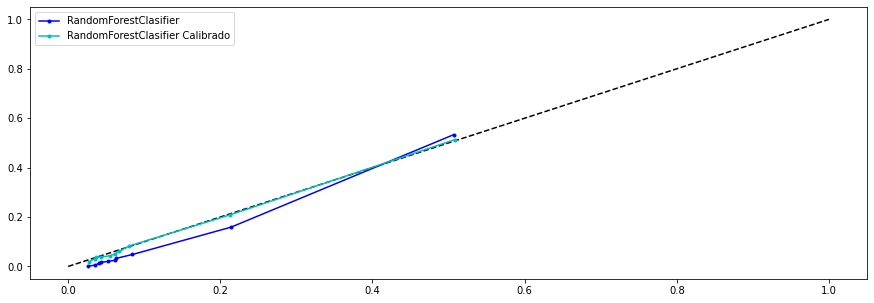

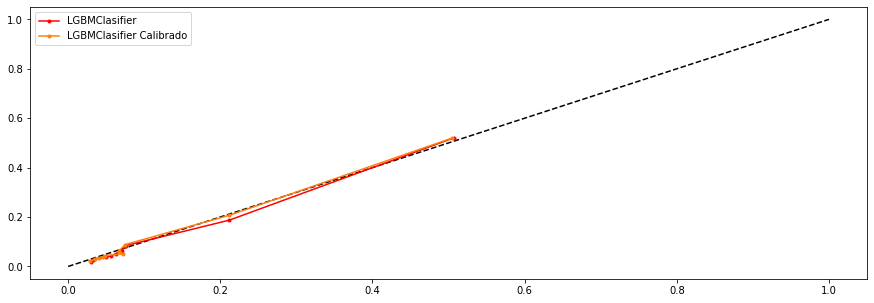

In [10]:
from sklearn.calibration import CalibratedClassifierCV

cccv1 = CalibratedClassifierCV(
    RandomForestClassifier(random_state=61658,n_estimators=500,**grid1.best_params_),
    method='isotonic',
    cv=10
)

cccv1.fit(X_tr, y_tr)
pred_1 = grid1.predict_proba(X_ts)[:,1]
pred_1_c = cccv1.predict_proba(X_ts)[:,1]

cccv2 = CalibratedClassifierCV(
    LGBMClassifier(random_state=61658,**grid2.best_params_),
    method='isotonic',
    cv=10
)

cccv2.fit(X_tr, y_tr)
pred_2 = grid2.predict_proba(X_ts)[:,1]
pred_2_c = cccv2.predict_proba(X_ts)[:,1]


########
plt.figure(figsize=(15,5))
plt.plot((0,1),(0,1),'k--')

fraction_of_positives1, mean_predicted_value1 = calibration_curve(y_ts, pred_1, n_bins=10, normalize=True, strategy='quantile')
plt.plot(fraction_of_positives1, mean_predicted_value1,'b.-',label='RandomForestClasifier')

fraction_of_positives1_c, mean_predicted_value1_c = calibration_curve(y_ts, pred_1_c, n_bins=10, normalize=True, strategy='quantile')
plt.plot(fraction_of_positives1_c, mean_predicted_value1_c,'c.-',label='RandomForestClasifier Calibrado')

plt.legend()

plt.figure(figsize=(15,5))
plt.plot((0,1),(0,1),'k--')

fraction_of_positives2, mean_predicted_value2 = calibration_curve(y_ts, pred_2, n_bins=10, normalize=True, strategy='quantile')
plt.plot(fraction_of_positives2, mean_predicted_value2,'r.-',label='LGBMClasifier')

fraction_of_positives2_c, mean_predicted_value2_c = calibration_curve(y_ts, pred_2_c, n_bins=10, normalize=True, strategy='quantile')
plt.plot(fraction_of_positives2_c, mean_predicted_value2_c,'C1.-',label='LGBMClasifier Calibrado')

plt.legend()

# TODO: Dividir em decis, e calcular a faixa de probabilidade do decil

 - Aplicações:
   - Precificação: Desconto de X% **dado que** a probabilidade de compra é maior que tanto
   - Crédito bancário: Qual o meu **apetite de risco**?